# Optimal Control: 2D Turbulence Snapshot

In [1]:
using JLD2, Interpolations, Statistics, ForwardDiff

const n = 512 # grid resolution 
const L = 2π  # domain length           

##### Load Velocity Field #####
file = jldopen("../../Data Generation/2d-turb-data.jld")
u_data = file["vel_x"][:,:,1]
v_data = file["vel_y"][:,:,1]
vort_data = file["vort"][:,:,1]
close(file)

##### Interpolations #####
itp_vort = interpolate(vort_data, BSpline(Linear(Periodic())))
itp_u = interpolate(u_data, BSpline(Linear(Periodic())))
itp_v = interpolate(v_data, BSpline(Linear(Periodic())))

etp_vort = extrapolate(itp_vort, Periodic())
etp_u = extrapolate(itp_u, Periodic())
etp_v = extrapolate(itp_v, Periodic())

vort(x,y) = etp_vort(n*x/L+1, n*y/L+1)
velX(x,y) = etp_u(n*x/L+1, n*y/L+1)
velY(x,y) = etp_v(n*x/L+1, n*y/L+1)

##### Derivatives #####

velX_x(x,y) = ForwardDiff.derivative(z -> velX(z, y), x)
velX_y(x,y) = ForwardDiff.derivative(z -> velX(x, z), y)
velY_x(x,y) = ForwardDiff.derivative(z -> velY(z, y), x)
velY_y(x,y) = ForwardDiff.derivative(z -> velY(x, z), y)

##### Start, End #####
xA = 1.2
yA = 5.5
xB = 5.2
yB = 1.8

# Agent's velocity
V0 = 0.3*maximum(sqrt.(u_data.^2+v_data.^2)) 

nothing

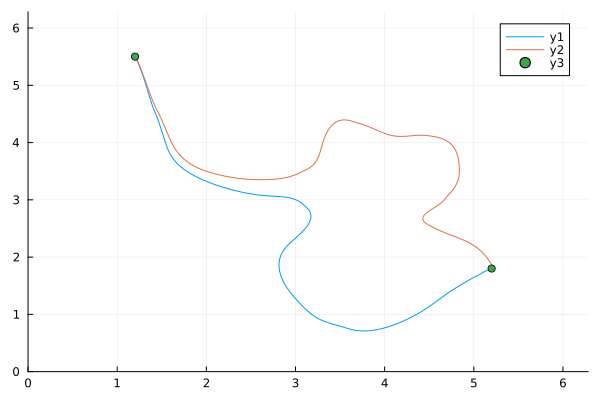

In [ ]:
using OrdinaryDiffEq,
      Optimization, OptimizationPolyalgorithms, SciMLSensitivity,
      Zygote, Plots

function advection!(du, u, p, t)
    x, y, z = u
    T = p[2]
    du[1] = dx = T*velX(x,y) + V0*T*cos(z)
    du[2] = dy = T*velY(x,y) + V0*T*sin(z)
    du[3] = dz = T*(velY_x(x,y)*sin(z)*sin(z) - velX_y(x,y)*cos(z)*cos(z) + sin(z)*cos(z)*(velX_x(x,y)-velY_y(x,y)))
end

# Simulation interval and intermediary points
tspan = (0.0, 1.0)
tsteps = 0.0:0.001:1.0

# System parameters (initial guess)
p1 = [-0.8836, 0.82]
p2 = [-0.86308115, 1.25]

u0_1 = [xA, yA, p1[1]]
u0_2 = [xA, yA, p2[1]]

# Setup the ODE problem, then solve
prob1 = ODEProblem(advection!, u0_1, tspan, p1)
prob2 = ODEProblem(advection!, u0_2, tspan, p2)
sol1 = solve(prob1, Tsit5(), reltol = 1e-12, abstol = 1e-12)
sol2 = solve(prob2, Tsit5(), reltol = 1e-12, abstol = 1e-12)

# Plot the solution
plot(t->sol1(t)[1], t->sol1(t)[2], 0, 1, xlim=(0, L), ylim=(0, L))
plot!(t->sol2(t)[1], t->sol2(t)[2], 0, 1, xlim=(0, L), ylim=(0, L))
scatter!([xA, xB], [yA, yB])

In [3]:
# Loss function to be minimized
function loss(p)
    prob = ODEProblem(advection!, [xA, yA, p[1]], tspan, p)
    sol = solve(prob, Tsit5(), p = p, saveat = tsteps, reltol = 1e-12, abstol = 1e-12)
    loss = (sol[end][1]-xB)^2 + (sol[end][2]-yB)^2
    return loss
end

# display value of loss during optimization
callback = function (state, l)
    if (state.iter % 100) == 0
        println("loss=", l)
    end
    return false
end

adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
optprob1 = Optimization.OptimizationProblem(optf, p1)
optprob2 = Optimization.OptimizationProblem(optf, p2)

nothing

In [4]:
result1_ode = Optimization.solve(optprob1, PolyOpt(),
    callback = callback, reltol = 1e-8, abstol = 1e-8,
    maxiters = 300)

loss=11.25323288588418
loss=11.208531205636218
loss=6.872488484976508
loss=0.00048032858927761035
loss=0.00048032858927761035


retcode: Success
u: 2-element Vector{Float64}:
 -0.8836008553027104
  0.8199981549204088

In [5]:
result2_ode = Optimization.solve(optprob2, PolyOpt(),
    callback = callback, reltol = 1e-8, abstol = 1e-8,
    maxiters = 300)

loss=7.977116022619407
loss=7.948971082890088
loss=7.896025361762515
loss=0.0006413268365300492
loss=0.0006413268365300492


retcode: Failure
u: 2-element Vector{Float64}:
 -0.8630811520944798
  1.250000004104878

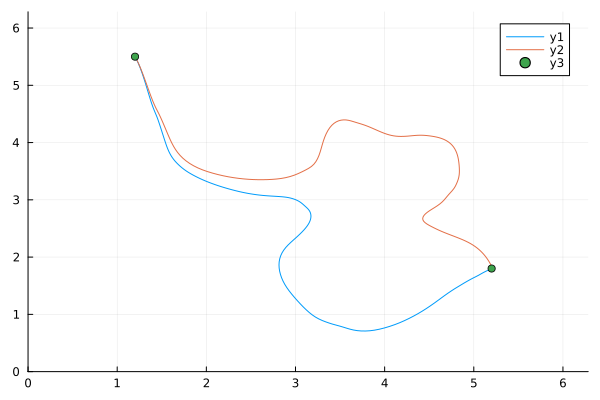

In [6]:
# optimal control solution:
p1_opt = result1_ode.u
prob1_opt = ODEProblem(advection!, [xA, yA, p1_opt[1]], tspan, p1_opt)
opt1_solution = solve(prob1_opt, Tsit5(), p = p1_opt, saveat = tsteps, reltol = 1e-12, abstol = 1e-12)

p2_opt = result2_ode.u
prob2_opt = ODEProblem(advection!, [xA, yA, p2_opt[1]], tspan, p2_opt)
opt2_solution = solve(prob2_opt, Tsit5(), p = p2_opt, saveat = tsteps, reltol = 1e-12, abstol = 1e-12)

plot(t->opt1_solution(t)[1], t->opt1_solution(t)[2], 0, 1, xlim=(0, L), ylim=(0, L))
plot!(t->opt2_solution(t)[1], t->opt2_solution(t)[2], 0, 1, xlim=(0, L), ylim=(0, L))
scatter!([xA, xB], [yA, yB])

### Optimal Trajectory + Perturbations (Noise)

In [7]:
# generating trajectories with noisy initial control
ϵ = (pi/180)/50

p1 = [result1_ode.u[1]+ϵ, result1_ode.u[2]]
prob_p1 = ODEProblem(advection!, [xA, yA, p1[1]], tspan, p1)
p1_solution = solve(prob_p1, Tsit5(), p = p1, saveat = tsteps, reltol = 1e-12, abstol = 1e-12)

p2 = [result1_ode.u[1]-ϵ, result1_ode.u[2]]
prob_p2 = ODEProblem(advection!, [xA, yA, p2[1]], tspan, p2)
p2_solution = solve(prob_p2, Tsit5(), p = p2, saveat = tsteps, reltol = 1e-12, abstol = 1e-12)

# generating trajectories with noisy start position
Δ = 1e-3

prob_p3 = ODEProblem(advection!, [xA+Δ, yA, p1_opt[1]], tspan, p1_opt)
p3_solution = solve(prob_p3, Tsit5(), p = p1_opt, saveat = tsteps, reltol = 1e-12, abstol = 1e-12)

prob_p4 = ODEProblem(advection!, [xA, yA+Δ, p1_opt[1]], tspan, p1_opt)
p4_solution = solve(prob_p4, Tsit5(), p = p1_opt, saveat = tsteps, reltol = 1e-12, abstol = 1e-12)

nothing

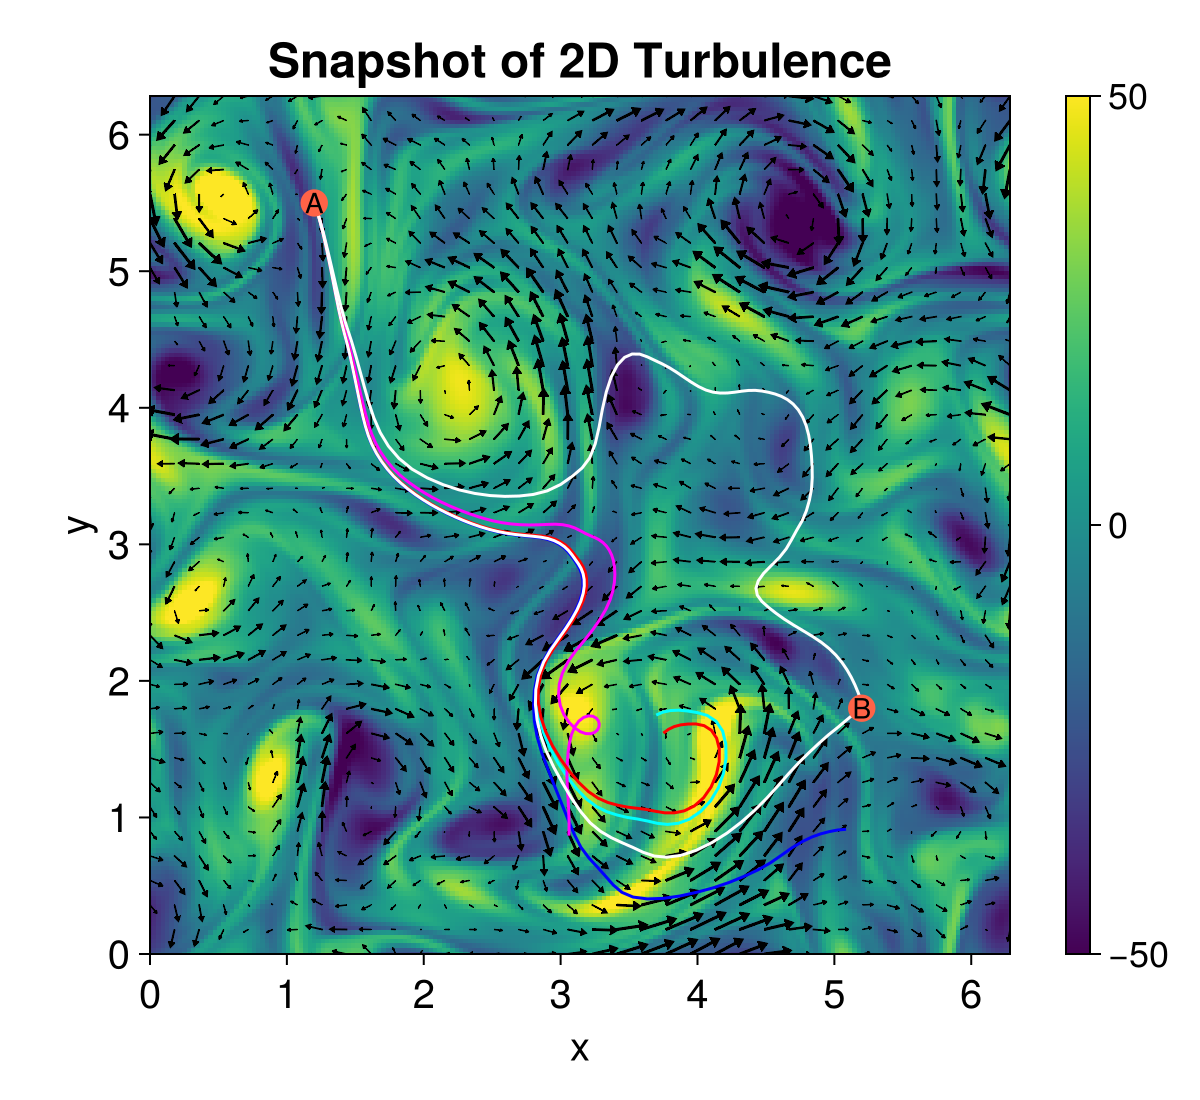

In [8]:
using CairoMakie

xs = range(0, 2*pi, length=200)
ys = range(0, 2*pi, length=200)
zs = [vort(x,y) for x in xs, y in ys]

xs2 = LinRange(0, 2*pi, 36)
ys2 = LinRange(0, 2*pi, 36)
us2 = [velX(x,y) for x in xs2, y in ys2]
vs2 = [velY(x,y) for x in xs2, y in ys2]

times = range(0, 1, length=100)
x_track = [opt1_solution(t)[1] for t in times]
y_track = [opt1_solution(t)[2] for t in times]

x1_track = [p1_solution(t)[1] for t in times]
y1_track = [p1_solution(t)[2] for t in times]

x2_track = [p2_solution(t)[1] for t in times]
y2_track = [p2_solution(t)[2] for t in times]

x3_track = [p3_solution(t)[1] for t in times]
y3_track = [p3_solution(t)[2] for t in times]

x4_track = [p4_solution(t)[1] for t in times]
y4_track = [p4_solution(t)[2] for t in times]

# second optimal trajectory
x0_track = [opt2_solution(t)[1] for t in times]
y0_track = [opt2_solution(t)[2] for t in times]

fig = Figure(size = (600, 550))

ax = Axis(fig[1, 1], title = "Snapshot of 2D Turbulence", titlesize = 24,
    xlabel = "x", xlabelsize=20, xticklabelsize=20,
    ylabel = "y", ylabelsize=20, yticklabelsize=20,
    aspect = 1, limits = ((0, 2*pi), (0, 2*pi))
)

hm = CairoMakie.heatmap!(ax, xs, ys, zs, colormap = :viridis, alpha=1.0, colorrange=(-50, 50))
Colorbar(fig[:, end+1], hm, ticklabelsize=18)

arrows2d!(ax, xs2, ys2, us2, vs2, lengthscale = 0.02, tiplength=4, tipwidth=6,
            shaftwidth=1.5)

lines!(ax, x1_track, y1_track, color=:cyan)
lines!(ax, x2_track, y2_track, color=:blue)
lines!(ax, x3_track, y3_track, color=:magenta)
lines!(ax, x4_track, y4_track, color=:red)
lines!(ax, x0_track, y0_track, color=:white)
lines!(ax, x_track, y_track, color=:white)

poly!(ax, Circle(Point2f(xA, yA), 0.1), color = :tomato)
text!(xA, yA, text = "A", align = (:center, :center))

poly!(ax, Circle(Point2f(xB, yB), 0.1), color = :tomato)
text!(xB, yB, text = "B", align = (:center, :center))

save("2d-turb-snapshot.pdf", fig)
fig

# Lyapunov Exponents

In [9]:
dS = [1e-7, 1e-7, 1e-7]  #[dx,dy,dθ]

# Simulation interval and intermediary points
tspan = (0.0, 1.0)
tsteps = 0.0:0.001:1.0

p1_opt = [-0.8836008560984615, 0.8199981595228619]
prob1_opt = ODEProblem(advection!, [xA, yA, p1_opt[1]], tspan, p1_opt)
opt1_solution = solve(prob1_opt, Tsit5(), p = p1_opt, saveat = tsteps, reltol = 1e-18, abstol = 1e-18)

# perturbed solutions
prob_S1 = ODEProblem(advection!, [xA+dS[1], yA, p1_opt[1]], tspan, p1_opt)
pS1_solution = solve(prob_S1, Tsit5(), p = p1_opt, saveat = tsteps, reltol = 1e-18, abstol = 1e-18)

prob_S2 = ODEProblem(advection!, [xA, yA+dS[2], p1_opt[1]], tspan, p1_opt)
pS2_solution = solve(prob_S2, Tsit5(), p = p1_opt, saveat = tsteps, reltol = 1e-18, abstol = 1e-18)

p_dS = [p1_opt[1]+dS[3], p1_opt[2]]
prob_S3 = ODEProblem(advection!, [xA, yA, p_dS[1]], tspan, p_dS)
pS3_solution = solve(prob_S3, Tsit5(), p = p_dS, saveat = tsteps, reltol = 1e-18, abstol = 1e-18)

nothing

In [10]:
times = range(0, 1, length=100)
T = p1_opt[2]

# construction of matrix W from perturbed solutions
W11 = [(pS1_solution(t)[1] - opt1_solution(t)[1])/dS[1] for t in times]
W21 = [(pS1_solution(t)[2] - opt1_solution(t)[2])/dS[1] for t in times]
W31 = [(pS1_solution(t)[3] - opt1_solution(t)[3])/dS[1] for t in times]

W12 = [(pS2_solution(t)[1] - opt1_solution(t)[1])/dS[2] for t in times]
W22 = [(pS2_solution(t)[2] - opt1_solution(t)[2])/dS[2] for t in times]
W32 = [(pS2_solution(t)[3] - opt1_solution(t)[3])/dS[2] for t in times]

W13 = [(pS3_solution(t)[1] - opt1_solution(t)[1])/dS[3] for t in times]
W23 = [(pS3_solution(t)[2] - opt1_solution(t)[2])/dS[3] for t in times]
W33 = [(pS3_solution(t)[3] - opt1_solution(t)[3])/dS[3] for t in times]

nothing

In [11]:
using LinearAlgebra

l1 = zeros(100)
l2 = zeros(100)
l3 = zeros(100)

# calculation of Lyapunov exponents 
for i in 1:100
    W = [W11[i] W12[i] W13[i]; W21[i] W22[i] W23[i]; W31[i] W32[i] W33[i]]
    l1[i], l2[i], l3[i] = log.(svdvals(W))/(times[i])
end

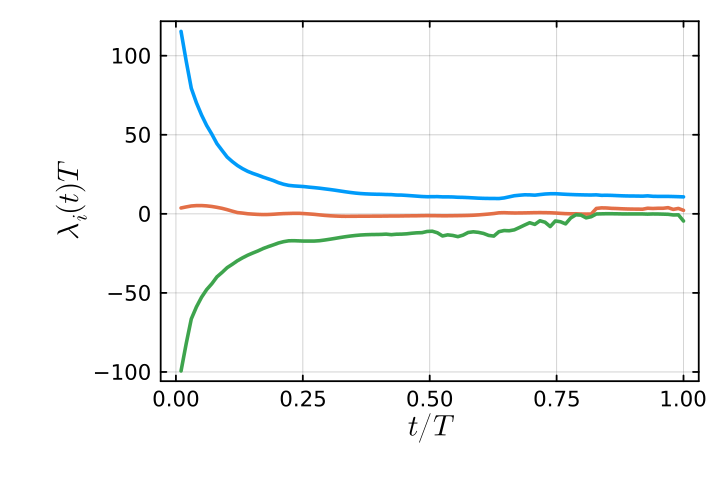

In [12]:
using LaTeXStrings

p = Plots.plot(times, [l1, l2, l3], framestyle=:box, lw=2, xlabel=L"t/T", ylabel=L"\lambda_i(t)T",
    legend=false, dpi=120, thickness_scaling=1.5,)

savefig(p, "2d-turb-snapshot FTLE.pdf")
p